In [501]:
import json
import pickle
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from sklearn import preprocessing

Load files

In [502]:
# JSON file path
#json_path = './recipe_1m_ingredients_extracted.json'
all_json_path = './1mtest_all_440_labels.json'
train_json_path = './1mtest_train_440_labels.json'
test_json_path = './1mtest_test_440_labels.json'
val_json_path = './1mtest_val_440_labels.json'

# Open the JSON file
#with open(json_path, 'r') as file:
    #json_data = json.load(file)

with open(all_json_path, 'r') as file:
    all_json_data = json.load(file)
    
with open(train_json_path, 'r') as file:
    train_json_data = json.load(file)

with open(test_json_path, 'r') as file:
    test_json_data = json.load(file)

with open(val_json_path, 'r') as file:
    val_json_data = json.load(file)

Exception ignored in: <function tqdm.__del__ at 0x000001B98A2BDA80>
Traceback (most recent call last):
  File "c:\Users\Helin\anaconda3\envs\hlcv\Lib\site-packages\tqdm\std.py", line 1145, in __del__
    self.close()
  File "c:\Users\Helin\anaconda3\envs\hlcv\Lib\site-packages\tqdm\std.py", line 1262, in close
    def close(self):

KeyboardInterrupt: 


Get set of unique ingredients

In [ ]:
def get_unique_ingredients(all_data):
    unique_ingredients = set()
    ing_dict = {key: np.array(val) for key, val in all_data['cleaned_ingredients'].items()}
    for val in ing_dict.values():
        unique_ingredients.update(val)
    return np.array(list(unique_ingredients))

def get_ingredients_lists(all_data):
    ing_dict = {key: np.array(val) for key, val in all_data['cleaned_ingredients'].items()}
    return ing_dict.values()

Get unique ingredients set from all_json_data

In [ ]:
unique_ingredients = get_unique_ingredients(all_json_data)
ing_lists = get_ingredients_lists(all_json_data)
mlb = preprocessing.MultiLabelBinarizer()
mlb.fit(ing_lists)
ohe = preprocessing.OneHotEncoder()
ohe.fit(unique_ingredients.reshape(-1, 1))
pickle.dump(mlb, open('mlb.pkl', 'wb'))

OneHotEncoder()

Compute max label length for sklearn.LabelEncoder()

In [ ]:
def compute_max_len(label_dict):
    max_len = 0
    for labels in label_dict.values():
        max_len = max(max_len, len(labels))
    return max_len

Label padding

In [ ]:
'''
def label_padding(label_dict, max_len):
    for key, val in label_dict.items():
        label_dict[key] = val + ['<pad>'] * (max_len - len(val))
    return label_dict
'''
def label_padding(label_dict, max_len):
    for key, val in label_dict.items():
        label_dict[key] = np.pad(val, (0, max_len - len(val)), 'constant', constant_values=-1)
    return label_dict

Ingredients from str to numerical

In [ ]:

def str2num_le(str_dict):
    le = preprocessing.LabelEncoder()
    unique_ingredients = get_unique_ingredients(str_dict)
    le.fit(list(unique_ingredients))
    for key, val in str_dict.items():
        str_dict[key] = np.array(le.transform(list(val)))
    return str_dict,le

def str2num_ohe(str_dict, encoder):
    for key, value in str_dict.items():
        str_dict[key] = encoder.transform(np.array(value).reshape(-1, 1)).toarray()
    return str_dict

def str2num(str_dict, encoder):
    num_dict = {}
    key_arr = np.array(list(str_dict.keys()))
    val_arr = []
    for val in str_dict.values():
        val_arr.append(val)
    val_arr = encoder.transform(val_arr)
    for k in range(len(key_arr)):
        num_dict[key_arr[k]] = val_arr[k]
    return num_dict

Get image path from filename

In [ ]:
def get_img_path(img_id):
    dir = "./test/"
    img_path = dir + [*img_id][0] + '/' + [*img_id][1] + '/' + [*img_id][2] + '/' + [*img_id][3] + '/' + img_id
    return img_path

Create dictionaries, convertit into a desired structure

In [ ]:
def get_paired_dict(json_data):
    #ingredient_dict = json_data['extracted ingredients']
    ing_dict = json_data['cleaned_ingredients']
    image_dict = json_data['image_file_name_ls']

    # Method to make the ingredient dict in the form of string: list of strings
    #def list_of_dicts_to_array(dict_list):
        #return np.array([d['text'] for d in dict_list])

    #convert the ingredients dict
    #ingredient_dict = {key: list_of_dicts_to_array(val) for key, val in ingredient_dict.items()}
    #max_len = compute_max_len(ingredient_dict)
    #ingredient_dict = label_padding(ingredient_dict, max_len)
    #pair the image ids and ingredients
    paired_dict = {}
    assert len(image_dict) == len(ing_dict), "The number of images and corresponding ingredients lists are not equal"
    
    #ingredient_dict_le,le = str2num_le(ingredient_dict)
    ing_dict = str2num(ing_dict, mlb)
    for image_list, ingredient_list in zip(image_dict.values(), ing_dict.values()):
        for image in image_list:
            paired_dict[image] = ingredient_list
    return paired_dict

In [ ]:
train_paired_dict = get_paired_dict(train_json_data)
test_paired_dict = get_paired_dict(test_json_data)
val_paired_dict = get_paired_dict(val_json_data)
for k,v in train_paired_dict.items():
    print(k,len(v), np.count_nonzero(v))

589aa53634.jpg 440 8
5ec5605334.jpg 440 8
80e94b8784.jpg 440 8
a52c9f8281.jpg 440 8
50bc445af6.jpg 440 12
a47a00e626.jpg 440 8
cf4109048c.jpg 440 5
616182b964.jpg 440 4
86df540950.jpg 440 6
00f783a572.jpg 440 11
f035c5b1fb.jpg 440 5
9e05cfda34.jpg 440 4
3319b6c5fa.jpg 440 7
028c4624f6.jpg 440 6
85a25ec69c.jpg 440 6
7ca512f1ff.jpg 440 14
4f6d76e2d3.jpg 440 6
5fa6fa1928.jpg 440 5
25329b1044.jpg 440 6
38c1404ebb.jpg 440 6
3d8e9459e2.jpg 440 6
622d0656f5.jpg 440 6
7aa851ade6.jpg 440 6
af5323445d.jpg 440 6
f51e2e8f57.jpg 440 8
f4c79db975.jpg 440 9
f0b33fcf0c.jpg 440 4
7dfdfa8e8d.jpg 440 5
bbaf70d853.jpg 440 7
afc4e5459b.jpg 440 4
9b198a2881.jpg 440 13
bca0f54644.jpg 440 8
22b1ad8f4a.jpg 440 14
a6dfec347b.jpg 440 14
927d990403.jpg 440 11
b4b85a98ef.jpg 440 11
7b8413d684.jpg 440 10
739126a930.jpg 440 12
75bf447fa2.jpg 440 5
9b54e4abff.jpg 440 9
8718706a81.jpg 440 15
34648363c5.jpg 440 13
aaba1e128a.jpg 440 13
ef44db264a.jpg 440 13
ff27e7afea.jpg 440 13
f69448d64c.jpg 440 1
d4d628c0d8.jpg 440 

In [ ]:
with open('train_paired_dict.pkl', 'wb') as file:
    pickle.dump(train_paired_dict, file)
with open('test_paired_dict.pkl', 'wb') as file:    
    pickle.dump(test_paired_dict, file)
with open('val_paired_dict.pkl', 'wb') as file:
    pickle.dump(val_paired_dict, file)  

In [ ]:
with open('train_paired_dict.pkl', 'rb') as file:
    train_paired_dict = pickle.load(file)
with open('test_paired_dict.pkl', 'rb') as file:    
    test_paired_dict = pickle.load(file)
with open('val_paired_dict.pkl', 'rb') as file:
    val_paired_dict = pickle.load(file)

Construct dataset

In [ ]:
class MyDataset(Dataset):
    def __init__(self, data_dict, transform=None):
        self.data_dict = data_dict
        self.transform = transform
    
    def __len__(self):
        return len(self.data_dict)
    
    def __getitem__(self, idx):
        image_id, ingredients = [*self.data_dict.items()][idx]
        image_path = get_img_path(image_id)
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        ingredients_tensor = torch.tensor(ingredients)
        return image, ingredients_tensor

ResNet to Extract Image Features

In [ ]:
#CUDA or not
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
# Load pre-trained ResNet model
resnet = models.resnet50(pretrained=True).to(device)
# Remove the classification layer
resnet = nn.Sequential(*list(resnet.children())[:-1])
# Set model to evaluation mode
resnet.eval()

# Define image preprocessing transforms
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

c:\Users\Helin\anaconda3\envs\hlcv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Helin\anaconda3\envs\hlcv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
train_set = MyDataset(train_paired_dict, transform=preprocess)
test_set = MyDataset(test_paired_dict, transform=preprocess)
val_set = MyDataset(val_paired_dict, transform=preprocess)

Clear CUDA Cache

In [ ]:
torch.cuda.empty_cache()

In [ ]:
train_loader = DataLoader(train_set, batch_size=16, shuffle=True, drop_last=True)
val_loader = DataLoader(val_set, batch_size=16, shuffle=True, drop_last=True)
test_loader = DataLoader(test_set, batch_size=16, shuffle=True, drop_last=True)

model = models.resnet50(pretrained=True)
num_in_ftrs = model.fc.in_features
model.fc = nn.Linear(num_in_ftrs, len(unique_ingredients))
model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

num_epochs = 10

Train iteration

In [ ]:
# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    # Use tqdm to iterate over the training data with a progress bar
    with tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as tqdm_loader:
        for i, data in enumerate(tqdm_loader, 0):
            # Get the inputs and labels from the data loader
            inputs, labels = data
            # Move inputs and labels to the device (e.g., GPU)
            inputs = inputs.to(device)
            labels = labels.to(device).float()
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(inputs)
            # Calculate the loss
            loss = criterion(outputs, labels)
            # Backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # Update the parameters by performing a single optimization step (parameter update)
            optimizer.step()
            # Add the loss for this batch to the running loss
            running_loss += loss.item()
            # Update tqdm progress bar with current loss
            tqdm_loader.set_postfix({'loss': loss.item()})
    # Print average loss for this epoch
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")
    
    # Save the model's state_dict after each epoch
    torch.save(model.state_dict(), f'model_train_epoch_{epoch+1}.pth')


Epoch 1/10: 100%|██████████| 6697/6697 [1:27:10<00:00,  1.28batch/s, loss=0.0644]


Epoch 1, Loss: 0.10700375711629066


Epoch 2/10: 100%|██████████| 6697/6697 [1:26:24<00:00,  1.29batch/s, loss=0.0561]


Epoch 2, Loss: 0.05781803728184612


Epoch 3/10: 100%|██████████| 6697/6697 [1:26:27<00:00,  1.29batch/s, loss=0.0596]


Epoch 3, Loss: 0.054288499068974455


Epoch 4/10: 100%|██████████| 6697/6697 [1:26:35<00:00,  1.29batch/s, loss=0.0476]


Epoch 4, Loss: 0.05273960712544505


Epoch 5/10: 100%|██████████| 6697/6697 [1:28:09<00:00,  1.27batch/s, loss=0.0547]


Epoch 5, Loss: 0.05179113778831515


Epoch 6/10: 100%|██████████| 6697/6697 [1:27:46<00:00,  1.27batch/s, loss=0.0503]


Epoch 6, Loss: 0.05112678274941725


Epoch 7/10: 100%|██████████| 6697/6697 [1:26:04<00:00,  1.30batch/s, loss=0.0454]


Epoch 7, Loss: 0.05061166723546242


Epoch 8/10: 100%|██████████| 6697/6697 [1:26:48<00:00,  1.29batch/s, loss=0.0581]


Epoch 8, Loss: 0.05020990510613985


Epoch 9/10: 100%|██████████| 6697/6697 [1:27:22<00:00,  1.28batch/s, loss=0.0442]


Epoch 9, Loss: 0.049854355225220214


Epoch 10/10: 100%|██████████| 6697/6697 [1:27:08<00:00,  1.28batch/s, loss=0.0545]

Epoch 10, Loss: 0.04954800083543518


Validation Iteration

Validation:   0%|          | 0/814 [00:00<?, ?batch/s]

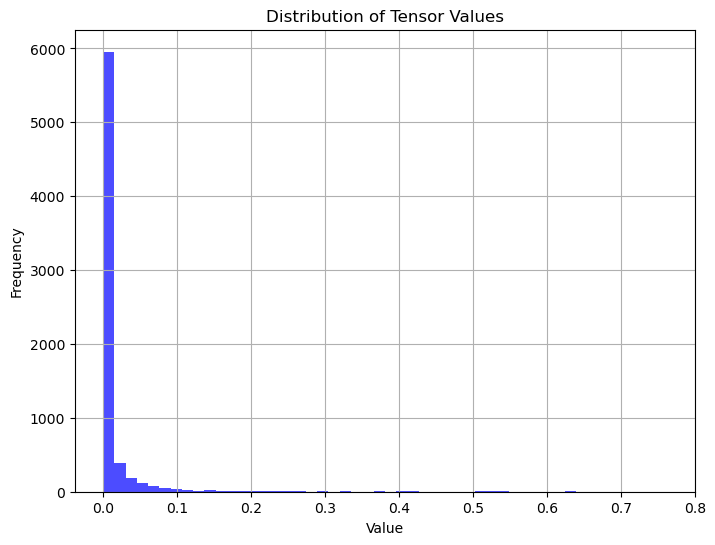

Validation:   0%|          | 0/814 [00:01<?, ?batch/s]


TypeError: imshow() missing 1 required positional argument: 'X'

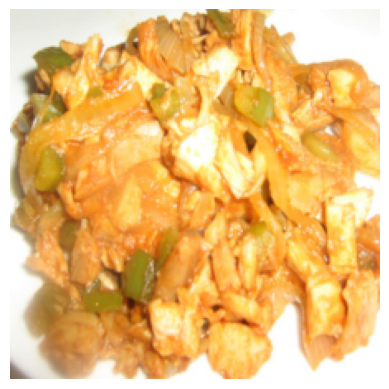

In [503]:
import matplotlib.pyplot as plt

model = resnet50

model.eval()  # Set the model to evaluation mode
val_running_loss = 0.0
val_correct = 0
val_total = 0

# Disable gradient calculation to speed up inference
with torch.no_grad():
    with tqdm(val_loader, desc=f'Validation', unit='batch') as tqdm_loader:
        for val_data in tqdm_loader:
            val_inputs, val_labels = val_data
            
            target_col = set()
            for row in val_labels:
                for col, value in enumerate(row):
                    if value == 1:
                        target_col.add(col)
            
            original_val_labels = val_labels
            
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device).float()
            
            #new_label = (val_labels == 1).sum(dim=0).cpu()
            new_label = val_labels.cpu()
            
            comparison = torch.all(original_val_labels == new_label)
            

            val_outputs = model(val_inputs)
            
            val_outputs = torch.sigmoid(val_outputs)
            values = val_outputs.cpu().view(-1).numpy()
            val_loss = criterion(val_outputs, val_labels)

            val_running_loss += val_loss.item()
            
            
            #print(torch.sum(prediction, dim=1))
            
            
            #print('#>threshold:',torch.sum(val_outputs > threshold, dim=1))
           
            #'''
            plt.figure(figsize=(8, 6))
            plt.hist(values, bins=50, color='blue', alpha=0.7)
            plt.title('Distribution of Tensor Values')
            plt.xlabel('Value')
            plt.ylabel('Frequency')
            plt.grid(True)
            plt.show()

            #'''
            
            predicted_col = set()
            binary_pred = (val_outputs > 0.1).float()
            for batch in binary_pred:
                for idx, value in enumerate(batch):
                    if value == 1:
                        predicted_col.add(idx)
                        
            intersection = predicted_col.intersection(target_col)
            pred_only = predicted_col - intersection
            target_only = target_col - intersection
            
            tp = len(intersection)
            fp = len(pred_only)
            fn = len(target_only)
            tn = len(unique_ingredients) - (tp + fp + fn)
            
            accuracy = (tp + tn) / (tp + fp + fn + tn)
            precision = tp / (tp + fp)
            recall = tp / (tp + fn)
            f1 = 2 * ((precision * recall) / (precision + recall))
            
            predicted_label = mlb.classes_[list(predicted_col)]
            target_label = mlb.classes_[list(target_col)]
            
            
            mean=[0.485, 0.456, 0.406]
            std=[0.229, 0.224, 0.225]
            unnormalize = transforms.Normalize(mean=[-m/s for m, s in zip(mean, std)], std=[1/s for s in std])
            unnormalized_img_tensor = unnormalize(val_inputs)[0]
            unnormalized_tensor = torch.clamp(unnormalized_img_tensor, 0, 1)
            to_pil = transforms.ToPILImage()
            image = to_pil(unnormalized_tensor) 
            plt.imshow(image)
            plt.axis('off')
            plt.imshow()
            
            tqdm_loader.set_postfix(accuracy=accuracy, precision=precision, recall=recall, f1=f1)
            
            #print(indices)
            #for row in val_labels:
                #print(row)
            '''
            # Calculate accuracy
            #prediction = (val_outputs > threshold)
            #val_total += val_labels.size(0)
            #val_correct += ((prediction == val_labels).sum(dim=1) == val_labels.size(1)).sum().item()

            tqdm_loader.set_postfix(val_loss=val_loss.item(), val_accuracy=(val_correct / val_total) * 100)
            '''
# Calculate validation loss and accuracy
val_loss = val_running_loss / len(val_loader)
val_accuracy = 100 * val_correct / val_total

#print(f"Validation Loss: {val_loss}, Accuracy: {val_accuracy}%")
print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1: {f1}")

Test Iteration

In [ ]:
model.eval()  # Set the model to evaluation mode
test_running_loss = 0.0
test_correct = 0
test_total = 0

# Disable gradient calculation to speed up inference
with torch.no_grad():
    with tqdm(test_loader, desc=f'Testing', unit='batch') as tqdm_loader:
        for test_data in tqdm_loader:
            test_inputs, test_labels = test_data
            test_inputs = test_inputs.to(device)
            test_labels = test_labels.to(device).float()

            test_outputs = model(test_inputs)
            test_loss = criterion(test_outputs, test_labels)

            test_running_loss += test_loss.item()

            # Calculate accuracy
            _, predicted = torch.max(test_outputs, 1)
            test_total += test_labels.size(0)
            test_correct += (predicted == test_labels).sum().item()

            tqdm_loader.set_postfix(test_loss=test_loss.item(), test_accuracy=(test_correct / test_total) * 100)

# Calculate test loss and accuracy
test_loss = test_running_loss / len(test_loader)
test_accuracy = 100 * test_correct / test_total

print(f"Test Loss: {test_loss}, Accuracy: {test_accuracy}%")


Placeholder